In [3]:
import torch
import torch.nn as nn
import torchvision
from skimage import io, transform
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage.transform import resize
import torch.nn.functional as F


In [4]:
class MobileKey(nn.Module):
    def __init__(self, num_classes):
        super(MobileKey, self).__init__()
        # self.pretrain_net = torchvision.models.squeezenet1_1(pretrained=True)
        self.pretrain_net = torchvision.models.MobileNetV2()
        self.base_net = self.pretrain_net.features
        self.conv0 = nn.Conv2d(in_channels=1280, out_channels=512, kernel_size=3, stride=2)
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=32, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=1)
        self.pooling1 = nn.AdaptiveAvgPool2d(output_size=(2, 1))

    def forward(self, x):
        x = self.base_net(x)
        x = F.relu(self.conv0(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.conv1(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.conv2(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.conv3(x))
        x = F.dropout(x, 0.2)
        x = F.relu(self.pooling1(x))
        x = x.squeeze(3)
        return x

In [5]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MobileKey(21)
model.load_state_dict(torch.load("mobile_key.pth"), strict=False)
model.eval()

MobileKey(
  (pretrain_net): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=F

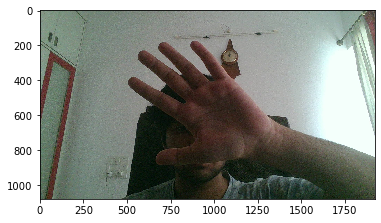

In [6]:
img_path = "test_img.jpg"
image = io.imread(img_path)
plt.imshow(image)

In [7]:
class Rescale(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))


        return img
    

In [8]:
image_transforms = transforms.Compose([Rescale((256,256)), 
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
                                       ])

In [9]:
image_t = image_transforms(image)
image_s = image_t.unsqueeze(0)

In [10]:
lands = model(image_s.float())
lands = torch.reshape(lands, shape=(21,2))

In [11]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    print(image.shape)
    n_img = resize(image,(256,256))
    plt.imshow(n_img)
    plt.scatter(landmarks[:, 0].detach().numpy(), landmarks[:, 1].detach().numpy(), s=10, marker='.', c='r')
    plt.pause(0.001)

(1080, 1920, 3)


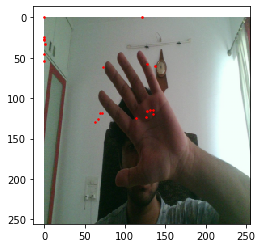

In [12]:
show_landmarks(image, landmarks=lands)

In [47]:
a = torch.tensor([[1,1], [1,1]])
b = torch.tensor([[2,1], [2,2]])
torch.pairwise_distance(a,b)

tensor([1.0000, 1.4142])